# Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy, and conclusions can be drawn.

Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientists to work on more high level topics.

In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

# Challenge Description 

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

You are asked to:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.


# Data

There are two tables in this project.


"test_table" - general information about the test results.

**Columns**:
* **user_id** : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
* **date** : when they came to the site for the first time since the test started
* **source** : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
* **device** : device used by the user. It can be mobile or web
* **browser_language** : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
* **browser** : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
* **conversion** : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
* **test** : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

"user_table" - some information about the user.

**Columns**:
* **user_id** : the id of the user. It can be joined to user id in the other table 
* **sex** : user sex: Male or Female
* **age** : user age (self-reported)
* **country** : user country based on ip address

# Solution

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind

In [9]:
test = pd.read_csv('test_table.csv')
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [11]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [12]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [13]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [14]:
user.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


## Check Uniqueness

user_id in each tables is unique. It can be used as primary key to merge two tables.

In [15]:
test['user_id'].nunique()==len(test)

True

In [16]:
user['user_id'].nunique()==len(user)

True

In [37]:
data = pd.merge(test,user,how='inner',on='user_id')

## EDA

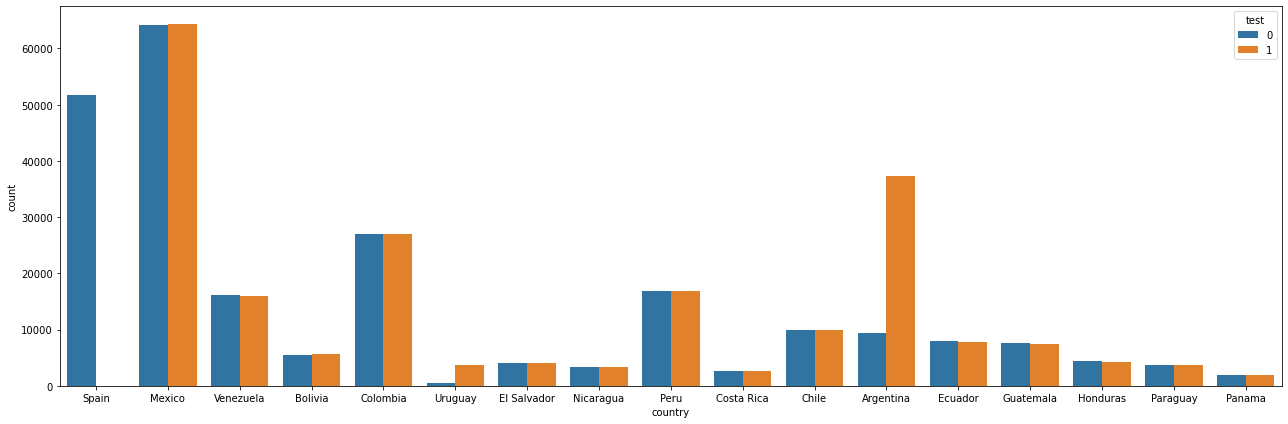

In [18]:
plt.figure(figsize=(18,6))
sns.countplot(x='country',hue='test',data=data)
plt.tight_layout()
plt.show()

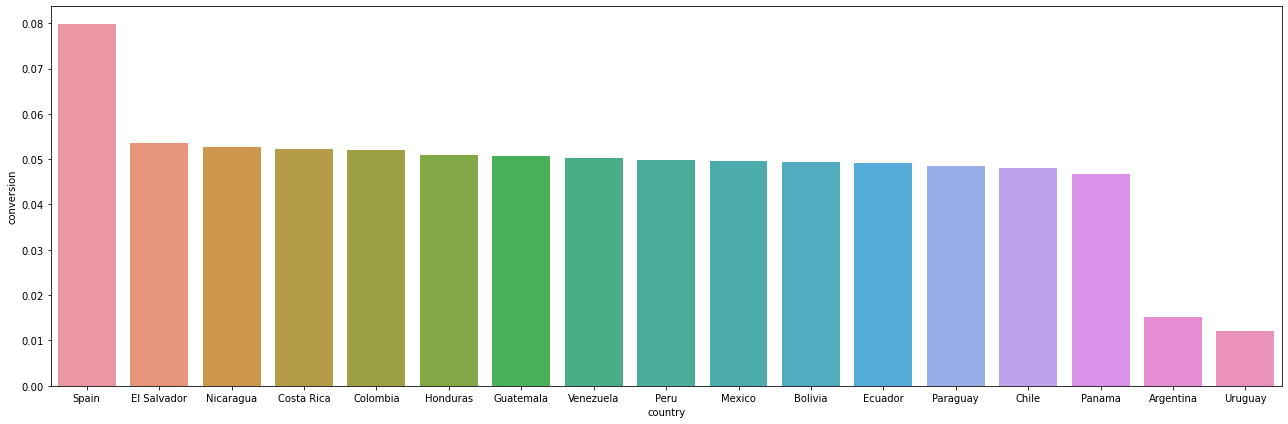

In [19]:
grouped_country = data[data['test']==0][['conversion','country']].groupby('country').mean().reset_index().sort_values('conversion',ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(x='country',y='conversion',data=grouped_country)
plt.tight_layout()
plt.show()


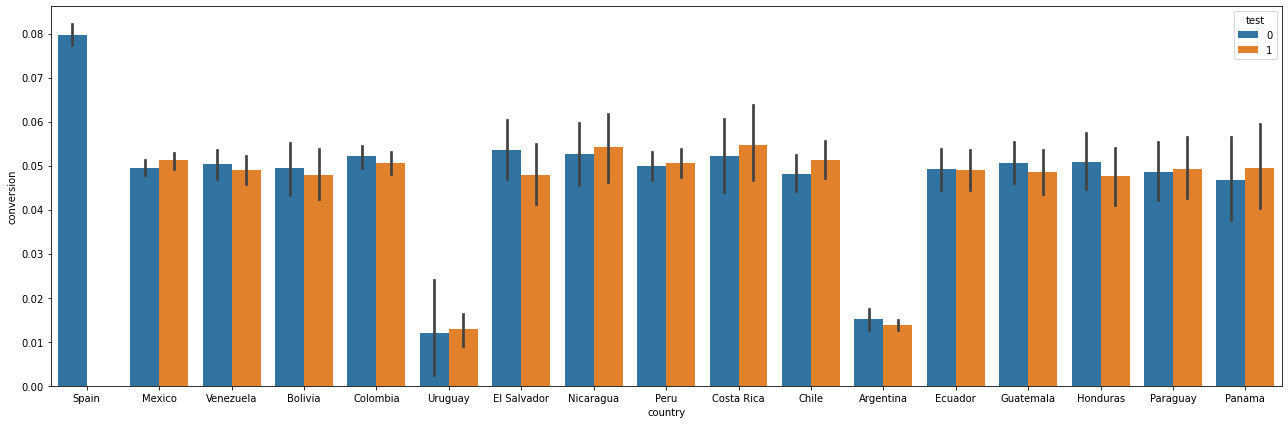

In [38]:
plt.figure(figsize=(18,6))
sns.barplot(x='country',y='conversion',hue='test',data=data)
plt.tight_layout()
plt.show()


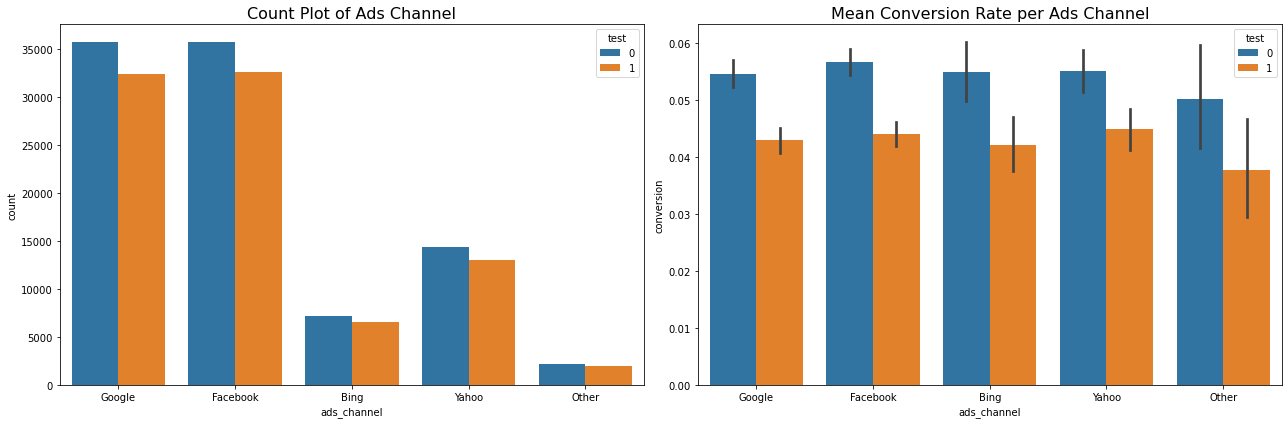

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='ads_channel', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Ads Channel', fontsize=16)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Ads Channel', fontsize=16)
plt.tight_layout()
plt.show()

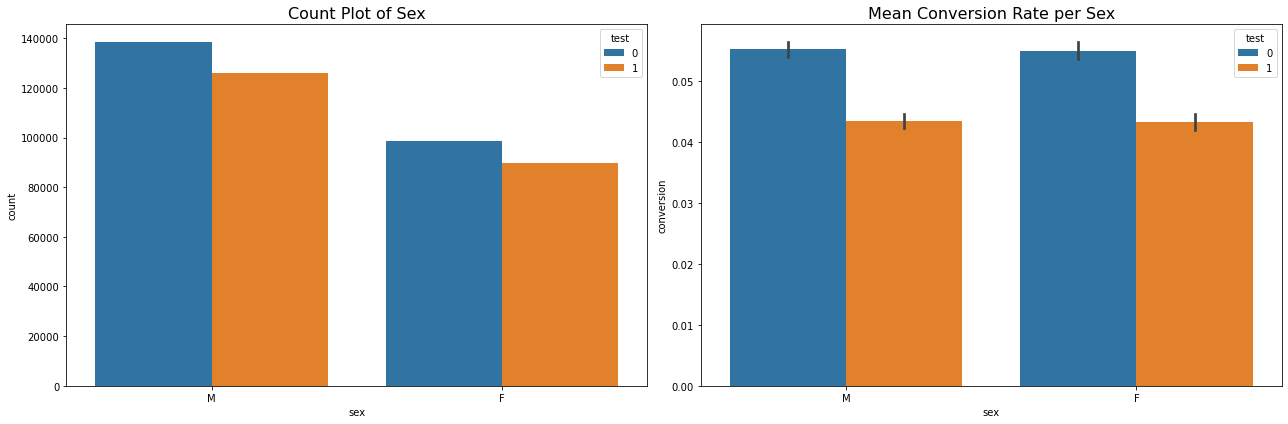

In [41]:
# Visualization of different Sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='sex', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Sex', fontsize=16)

sns.barplot(x='sex', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Sex', fontsize=16)
plt.tight_layout()
plt.show()

## Confirm that the test is actually negative.

## A/B test

$H_{0}$: The conversion rate of test group is better than conversion rate of control group. ${\mu}_{test} \geqslant \mu_{control}$  
${H_a}$: The conversion rate of test group is less than conversion rate of control group. ${\mu}_{test} < \mu_{control}$  

### T-test

I decide to use t-test to test the mean of conversion rate between control group and test group. 
Before using the stats.ttest_ind to compare two datasets, we have to check if the variance of two datasets is equal.

In [21]:
test_conversion=data[(data['test']==1) & (data['country']!='Spain')]['conversion']
control_conversion=data[(data['test']==0)& (data['country']!='Spain')]['conversion']

print("Test group's mean conversion rate is {}%".format(np.round(test_conversion.mean(),4)*100))
print("Control group's mean conversion rate is {}%".format(np.round(control_conversion.mean(),4)*100))
stats.levene(test_conversion,control_conversion)

Test group's mean conversion rate is 4.34%
Control group's mean conversion rate is 4.83%


LeveneResult(statistic=54.497646998915, pvalue=1.5593292774404536e-13)

Based on Levene result p-value is less than 0.05. The variances aren't equal.

In [22]:
stats.ttest_ind(test_conversion,control_conversion,equal_var=False)

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)

P-value of t-test is less than 0.05, we should reject the null hypothesis. In this case, the local-translation make conversion worse.

## Explain why that might be happening. Are the localized translations really worse?

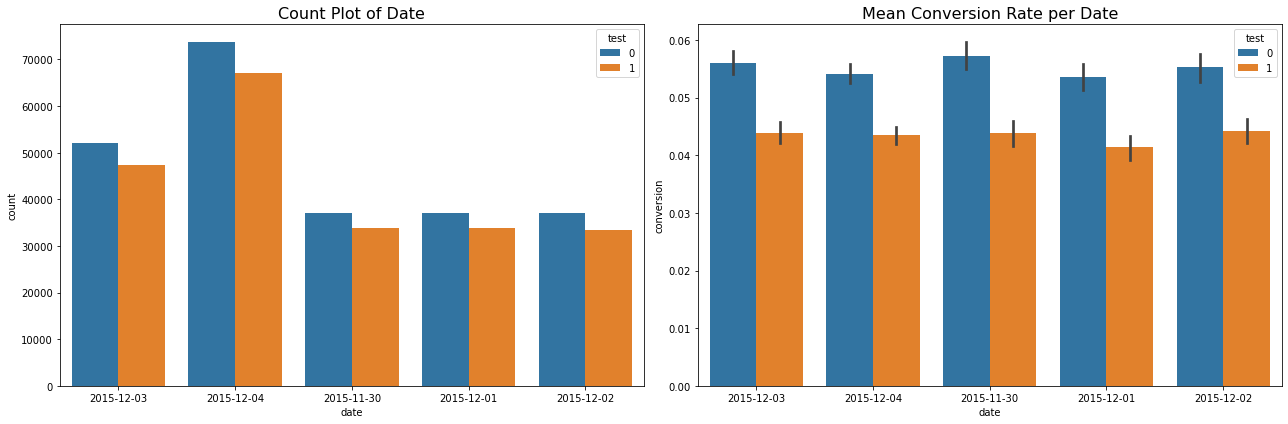

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

sns.barplot(x='date', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
control_grouped_date = data[data['test']==0 & (data['country']!='Spain')][['conversion','date']].groupby('date').mean().reset_index().sort_values('date',ascending=True)
test_grouped_date = data[data['test']==1 & (data['country']!='Spain')][['conversion','date']].groupby('date').mean().reset_index().sort_values('date',ascending=True)

Firstly, let's plot day by day to see if the worse situation has been constantly happening or they just started happening all of a sudden.

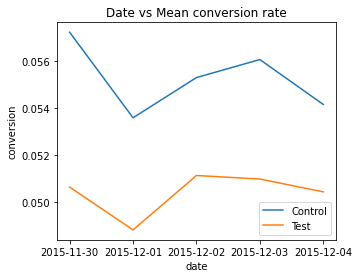

In [36]:
plt.subplots(1,1,figsize=(5,4))
plt.title('Date vs Mean conversion rate')
sns.lineplot(x='date',y='conversion',data=control_grouped_date,err_style='band',label='Control')
sns.lineplot(x='date',y='conversion',data=test_grouped_date,err_style='band',label='Test');
plt.legend();

Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.

In an ideal world, the distribution of people in test and control for each segment should be the same. But from the EDA section, I found that the number of control and test group in Argentina and Uruguary isn't equal to each other which is not acceptable since other countries all keep the 50/50 pattern. Let's check for each country. 

In [46]:
countries = [name for name in data['country'].unique() if name != 'Spain']

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values

    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue

    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

After we control for country, the test clearly appears not significant. Now we know that a localized translation does not result in conversion rate drop.

## Q3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.
 
The process we try to identify what was wrong tells us the main problem is about country variable. Our design for users in control or test group are not even on some countries, which might lead to noise for our experiment. Further, when calibrating the model on each country level, the result is not significant anymore. Thus, I tend to design an algorithm to sanity check problem about country, like if users are evenly divided into control and test groups, or if the result is significant on each country.

In [49]:
def sanitycheck(data,error):
    # no need to include users in Spain
    data = data[data['country']!='Spain']
    country_name = data['country'].dropna().unique()
    sig_country=[]
    print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.
          format('Country', 'Mean of Control','Mean of Test', 'P-Value', 'No.Control/No.Test'))
    print('-' * 85)
    # check each country
    for country in country_name:
        data_country = data[data['country']==country]
        # split into control and test group
        cont_country = data_country[data_country['test']==0]['conversion'].values
        test_country = data_country[data_country['test']==1]['conversion'].values
        p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
        if p_value < error:
            sig_country.append(country)
        ratio = len(cont_country)/len(test_country)
        print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.
              format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    if len(sig_country)==len(country_name):
        print('Everything is good and the result can be trusted!')
        return('TRUE')
    else:
        print('There is at least something wrong among one of countries, its result is not significant. Please check.' )
        return('FALSE')

In [50]:
sanitycheck(data,0.05)

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

'FALSE'